MPC for LTI systems and quadratic cost, with reference tracking

In [1]:
import numpy as np # arrays
import matplotlib.pyplot as plt # plots 
import control as ct # control systems library
import cvxpy as cp
from collections import namedtuple
import time as tt

Utility functions

In [2]:
def terminal_cost_set(p):
    '''
    Computes an ellipsoidal terminal set x^T * Qt * x <= 1 and an associated terminal cost
    x^T * P * x, on the basis of a nominal controller computed with the same cost weights as the MPC problem
    p: MPC controller parameters
     '''
    # Terminal controller, computed as an LQR
    K, P, _ = ct.dlqr(p.A, p.B, p.Q, p.R)
    K = -K
    
    # State constraints under the nominal controller
    Z = np.vstack((p.F,p.E @ K))
    z = np.vstack((p.f, p.e))

    (nz, _) = Z.shape
    (n, _) = p.A.shape

    # Compute the maximal sublevel set of the terminal cost x^T * P * x
    # that lies within the constraints for the terminal controller
    a = cp.Variable(nz)
    gamma = cp.Variable(1)
    epsi = np.finfo(float).eps

    constraints = [gamma >= epsi]
    for i in range(nz):
        constraints += [a[i] >= epsi]
        M2 = cp.bmat([[gamma*P, np.zeros([n,1])],[np.zeros([1,n]), [[-1]]]])
        M1 = cp.bmat([[np.zeros([n,n]), 0.5*Z[i,:].reshape(1,-1).T], [0.5*Z[i,:].reshape(1,-1), -z[i,:].reshape(1,-1)]])
        constraints += [-a[i]*M1 + M2 >> 0]

    problem = cp.Problem(cp.Minimize(gamma), constraints)
    problem.solve(solver='MOSEK')
    if problem.status != 'optimal':
        raise(ValueError("Infeasible problem in terminal set"))
    else:
        # Terminal set x^T * Qt * x <= 1
        Qt = gamma.value * P
    
        return P, Qt

In [3]:
def sampled_data_controller(controller, plant_dt): 
    """
    Create a discrete-time system that models the behaviour 
    of a digital controller. 
    
    The system that is returned models the behavior of a sampled-data 
    controller, including a sampler and a ZOH converter. 
    The returned system is discrete-time, and its timebase `plant_dt` is 
    much smaller than the sampling interval of the controller, 
    `controller.dt`, to insure that continuous-time dynamics of the plant 
    are accurately simulated. This system must be interconnected
    to a plant with the same dt. The controller's sampling period must be 
    greater than or equal to `plant_dt`, and an integral multiple of it. 
    The plant that is connected to it must be converted to a discrete-time 
    ZOH equivalent with a sampling interval that is also `plant_dt`. A 
    controller that is a pure gain must have its `dt` specified (not None). 
    """
    # the following is used to ensure the number before '%' is a bit larger 
    one_plus_eps = 1 + np.finfo(float).eps 
    assert np.isclose(0, controller.dt*one_plus_eps % plant_dt), \
        "plant_dt must be an integral multiple of the controller's dt"
    nsteps = int(round(controller.dt / plant_dt))
    step = 0
    y = np.zeros((controller.noutputs, 1))

    def updatefunction(t, x, u, params):  
        nonlocal step

        # Update the controller state only if it is time to sample
        if step == 0:
            x = controller._rhs(t, x, u)
        step += 1
        if step == nsteps:
            step = 0

        return x
           
    def outputfunction(t, x, u, params):
        nonlocal y
        
        # Compute controller action if it is time to sample
        if step == 0:
            y = controller._out(t, x, u)       
        return y

    # Return the controller system object
    return ct.ss(updatefunction, outputfunction, dt=plant_dt, 
                 name=controller.name, inputs=controller.input_labels, 
                 outputs=controller.output_labels, states=controller.state_labels)

In [4]:
def quadratic_mpc_problem(p):
    """
    Generate a cvxpy problem for the quadratic MPC step
    p: Controller parameters
        A,B: Model
        N: Horizon length
        Q, R: State and input weights for stage cost
        Fx <= f: State constraints
        Eu <= e: Input constraints
        Xf: if == None, use the trivial zero terminal constraint
            if == 'lqr', compute an ellipsoidal terminal set
            and quadratic terminal cost based on lqr with weights Q, R
    Parameters:
    x0: initial state
    returns cvxpy problem object with x0 as parameter
    """
    
    # State and input dimension
    (nx, nu) = p.B.shape

    # Define initial state as parameter  
    x0 = cp.Parameter(nx, name='x0')

    # Define state and input variables
    x = cp.Variable((nx, p.N + 1), name='x') # From k=0 to k=N
    u = cp.Variable((nu, p.N), name='u')     # From k=0 to k=N-1

    # Initialize cost and constraints
    cost = 0.0
    constraints = []
    
    # Generate cost and constraints
    for k in range(p.N):
        
        # Stage cost
        cost +=  cp.quad_form(x[:, k], p.Q)
        cost +=  cp.quad_form(u[:, k], p.R)

        # Dynamics constraint
        constraints += [x[:, k + 1] == p.A @ x[:, k] + p.B @ u[:, k]]

        # State constraints
        if p.F is not None:
            constraints += [p.F @ x[:, k] <= p.f.reshape(-1)]
        
    # Terminal cost and constraint:
    # if unspecified, fall back to trivial terminal constraint
    if p.Xf == 'lqr': # Ellipsoidal/lqr set/cost
        P,Qt = terminal_cost_set(p)
        cost += cp.quad_form(x[:, p.N], P)
        constraints += [cp.quad_form(x[:, p.N], Qt) <= 1]
    else:
        constraints += [x[:, p.N] == np.zeros_like(x0) ]
    
    # Input constraints
    if p.E is not None:
        constraints += [p.E @ u <= p.e]  

    # Initial state constraint
    constraints += [x[:, 0] == x0]

    # Generate cvx problem
    problem = cp.Problem(cp.Minimize(cost), constraints)
    
    # Return problem object
    return problem

In [5]:
def mpc_controller(parameters, T, **kwargs):
        """
        Create an I/O system implementing an MPC controller
        parameters: Controller parameters
            ref: Reference to be tracked
            A,B: Model
            N: Horizon length
            Q,R: Cost weights
        T: Sampling period
        """
        p = parameters
        typ = type
        nx, nu = p.B.shape
        no, _ = p.C.shape

        # Set up the cvxpy problem to be solved at each step

        # If there is a (constant) reference to track, compute
        # steady-state inputs/states and error system constraints
        if p.ref is not None:
            # Compute steady-state inputs and states
            Wsp = np.linalg.inv(np.block([ 
                      [np.eye(nx)-p.A, -p.B],
                      [p.C, np.zeros([no,nu]) ] ]))
            xusp = Wsp@np.block([[np.zeros([nx,1])] , [p.ref]])
            xsp = xusp[:nx]
            usp = xusp[-nu:]  
            # Compute constraints on error states and error inputs 
            p.f = p.f - p.F @ xsp
            p.e = p.e - p.E @ usp
        else:
            xsp = np.zeros([nx,1])
            usp = np.zeros([nu,1])
            
        # Generate cvxpy problem
        problem = quadratic_mpc_problem(p)
      
        # State x of the MPC controller is the current optimal sequence
        # while its input u is composed by current plant state
    
        # Controller state update function
        def _update(t, x, u, params={}):
            nonlocal nu, nx, p, problem, xsp, usp
 
            # Retrieve current plant state (take out dummy input)
            x0 = u[-nx:]
            
            # Pass it to cvxpy
            problem.param_dict['x0'].value = x0-xsp.reshape(-1)
                
            # Solve optimization problem
            problem.solve(solver='MOSEK', warm_start=True)
            if problem.status != 'optimal':
                raise(ValueError("Infeasible problem"))
            else:
                # Retrieve solution (optimal sequence) and return it
                res = problem.var_dict['u'].value
                return res.reshape(-1)

        # Controller output computation
        def _output(t, x, u, params={}):
            nonlocal nu, nx, p, problem, xsp, usp
            
            # Retrieve current plant state (take out dummy input)
            x0 = u[-nx:]
            
            # Pass state (minus offset if tracking) to cvxpy
            problem.param_dict['x0'].value = x0-xsp.reshape(-1)
                
            # Solve optimization problem
            problem.solve(solver='MOSEK', warm_start=True)
            if problem.status != 'optimal':
                raise(ValueError("Infeasible problem"))
            else:
                # Retrieve solution (optimal sequence)
                res = problem.var_dict['u'].value
                # Return first sample (plus offset if tracking)
                return res[:,0] + usp.reshape(-1)
               
        # Number of states of the controller    
        kwargs['states'] = nu * p.N
    
        return ct.NonlinearIOSystem(
            _update, _output, dt=T, **kwargs)

Main program

/Users/giannibi/anaconda3/envs/mpc/lib/python3.12/site-packages/cvxpy/expressions/constants/constant.py:53: UserWarning: Initializing a Constant with a nested list is undefined behavior. Consider using a numpy array instead.
  warnings.warn(NESTED_LIST_WARNING)
/Users/giannibi/anaconda3/envs/mpc/lib/python3.12/site-packages/mosek/__init__.py:18617: UserWarning: Argument sub in putvarboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putvarboundlist: Incorrect array format causing data to be copied");
/Users/giannibi/anaconda3/envs/mpc/lib/python3.12/site-packages/mosek/__init__.py:18925: UserWarning: Argument subj in putclist: Incorrect array format causing data to be copied
  warnings.warn("Argument subj in putclist: Incorrect array format causing data to be copied");
/Users/giannibi/anaconda3/envs/mpc/lib/python3.12/site-packages/mosek/__init__.py:18349: UserWarning: Argument sub in putconboundlist: Incorrect array format causing data to be c

'Simulation time:'

0.382979154586792

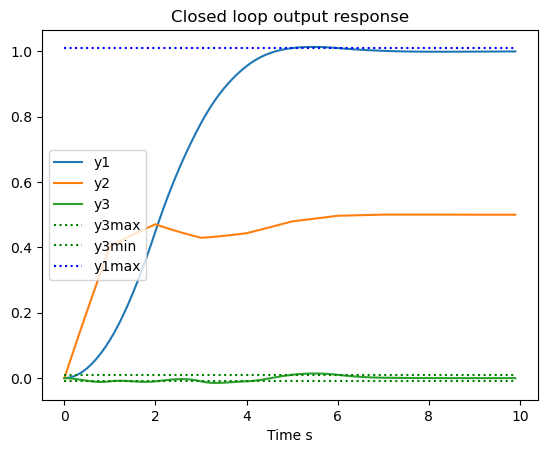

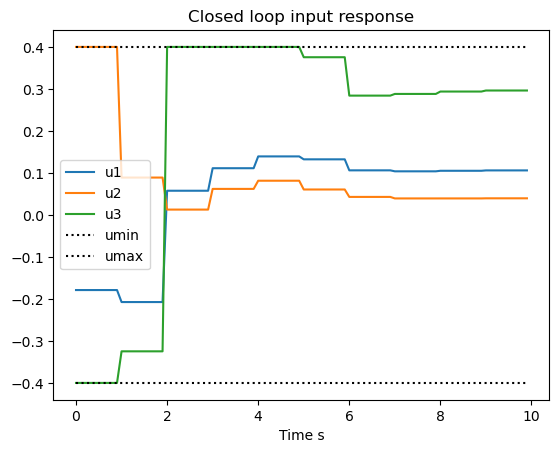

In [6]:
# Continuous-time plant model
A = np.array([ [0, 0, 1.1320, 0, 1],
    [0, -0.0538, -0.1712, 0, -0.0705],
    [0, 0, 0, 1, 0],
    [0, 0.0485, 0, -0.8556, 1.013],
    [0, 0.2909, 0, -1.0532, -0.6859]])
B = np.array([[0, 0, 0],
    [-0.120, 1, 0],
    [0, 0, 0],
    [4.4190, 0, -1.665],
    [-1.5750, 0, 0.0732]])
C = np.array([[1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0]])
D = np.zeros([3,3])

(no,nx) = C.shape
_, nu = B.shape

# Need to output both the actual output and the state
Ctot = np.vstack((C, np.eye(nx)))
Dtot = np.vstack((D, np.zeros([nx,nu])))

plant_continuous = ct.ss(A,B,Ctot,Dtot, 
                   inputs=['u[0]','u[1]','u[2]'], states=['x[0]','x[1]','x[2]','x[3]','x[4]'],
                   outputs=['y[0]','y[1]','y[2]','x[0]','x[1]','x[2]','x[3]','x[4]'])

# This is the step to simulate the continuous time plant (and the closed loop)
simulation_dt = 0.1
# Generate a discrete-time simulator of the plant with the simulation step
plant_simulator = ct.c2d(plant_continuous, simulation_dt, 'zoh')

# Controller sampling time
T = 1

# Generate discretized plant model for use with the controller
plant_discrete = ct.c2d(plant_continuous, T, 'zoh')

# MPC controller parameter structure field names
p = namedtuple('p', ['ref','A', 'B','C','N','Q','R','F','f','E','e','Xf'])

# Cost weights
p.Q = C.T @ C
p.R = 0.1*np.eye(3)

# Horizon length
p.N = 10

# Model
p.A = plant_discrete.A
p.B = plant_discrete.B
p.C = C

# State constraints
y3min = -0.01
y3max = 0.01
y1min = 0
y1max = 1.01
p.F = np.array([[0, 0, 1, 0, 0],
                [0, 0, -1, 0, 0],
                [1, 0, 0, 0, 0],
                [-1, 0, 0, 0, 0]])

p.f = np.array([[y3max],  
                [-y3min],
                [y1max],
                [-y1min]])

# Input constraints
umin = -0.4
umax = 0.4
p.E = np.array([[1, 0, 0],
                [-1, 0, 0],
                [0, 1, 0],
                [0, -1, 0],
                [0, 0, 1],
                [0, 0, -1]])

p.e = np.array([[umax],
                [-umin],
                [umax],
                [-umin],
                [umax],
                [-umin]])

# Constant reference to track (None for no tracking)
p.ref = np.array([[1],
                  [0.5],
                  [0]])

# Terminal set type
p.Xf = 'lqr'

# Define the MPC controller system object
controller = mpc_controller(p, T, 
                            inputs=['ref[0]','ref[1]','ref[2]','x[0]','x[1]','x[2]','x[3]','x[4]'],
                            outputs=['u[0]','u[1]','u[2]'])

# Create model of controller for simulation with the same integration time
# as the plant
controller_simulator = sampled_data_controller(controller, simulation_dt)

# Compute closed loop. The closed loop state has nu*p.N states (the controller states)
# plus nx states (the plant simulator states)
closedloop_simulator = ct.interconnect([controller_simulator, plant_simulator], 
                        inputs=['ref[0]','ref[1]','ref[2]'],
                        outputs=['y[0]','y[1]','y[2]','u[0]','u[1]','u[2]'],
                        states = nu*p.N + nx)

# Time vector for simulation
end_time = 10
time = np.arange(0, end_time, simulation_dt)

# Constant reference input: generate a matrix with a number of columns equal to
# the number of samples in the time vector and with each column equal to the
# reference vector
ref = np.array([p.ref.reshape(-1),] * time.size).transpose()

# The controller state is the optimal input sequence: we initialize it to zero
initu = np.zeros(nu*p.N)

# Initial plant state
initx0 = np.array([0,0,0,0,0])

# Closed loop initial state
initx = np.hstack((initu, initx0))

# Simulate
start_t = tt.time()
t, resp = ct.input_output_response(closedloop_simulator, time, ref, initx)
stop_t = tt.time()
display("Simulation time:", stop_t - start_t)

# Plot responses
y = resp[:no].T # extract output (first no components)
u = resp[-nu:].T # extract input (last nu components)
plt.plot(t, y, label=['y1','y2','y3'])
plt.plot(t, y3max*np.ones_like(t), 'g:', label='y3max')
plt.plot(t, y3min*np.ones_like(t), 'g:', label='y3min')
plt.plot(t, y1max*np.ones_like(t), 'b:', label='y1max')
plt.title("Closed loop output response")
plt.xlabel("Time s")
plt.legend();
plt.figure()
plt.plot(t, u, label=['u1','u2','u3'])
plt.plot(t, umin*np.ones_like(t), 'k:', label='umin')
plt.plot(t, umax*np.ones_like(t), 'k:', label='umax')
plt.xlabel("Time s")
plt.title("Closed loop input response")
plt.legend();